In [1]:
import polars as pl
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
from torch_geometric.data import HeteroData
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_float32_matmul_precision('medium')
torch.manual_seed(42)

In [2]:
X = pl.read_parquet("../../data/Processed_and_split/Processed_X.parquet")
y = pl.read_parquet("../../data/Processed_and_split/Processed_y.parquet")

In [3]:
src_ips = X['Source IP'].unique()
dest_ips = X['Destination IP'].unique()
unique_hosts = list(set(src_ips) | set(dest_ips))
host_id_map = {v: k for k, v in enumerate(unique_hosts)}
num_hosts = len(unique_hosts)
num_hosts

16272

In [4]:
host_features = torch.zeros(num_hosts, 0)

In [5]:
flow_features_df = X.drop(['Source IP', 'Destination IP', 'Source Port', 'Destination Port'])
flow_features = torch.tensor(flow_features_df.to_numpy(), dtype=torch.float32)
num_flows = flow_features.shape[0]

In [6]:
src_ids = X["Source IP"].to_list()
dst_ids = X["Destination IP"].to_list()

src_host_indices = torch.tensor([host_id_map[ip] for ip in src_ids])
dst_host_indices = torch.tensor([host_id_map[ip] for ip in dst_ids])

flow_indices = torch.arange(num_flows)

src_edge_index = torch.stack([src_host_indices, flow_indices], dim=0)
dst_edge_index = torch.stack([dst_host_indices, flow_indices], dim=0)

In [7]:
embedding_dim = 32
host_embedding = torch.nn.Embedding(num_hosts, embedding_dim)

host_indices = torch.arange(num_hosts)
host_features = host_embedding(host_indices)

data = HeteroData()
data['host'].x = host_features
data['flow'].x = flow_features

y = y['Label']

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y.to_list())
data['flow'].y = torch.tensor(y_encoded, dtype=torch.long)

In [8]:
data['host', 'src_of', 'flow'].edge_index = src_edge_index
data['host', 'dst_of', 'flow'].edge_index = dst_edge_index

# Optional reverse edges
data['flow', 'rev_src_of', 'host'].edge_index = src_edge_index.flip(0)
data['flow', 'rev_dst_of', 'host'].edge_index = dst_edge_index.flip(0)


data = data.to(device)

In [9]:
def split_masks(data, split=(0.7, 0.15, 0.15), seed=42):
    torch.manual_seed(seed)
    num_nodes = data['flow'].num_nodes
    perm = torch.randperm(num_nodes)

    train_end = int(split[0] * num_nodes)
    val_end = train_end + int(split[1] * num_nodes)

    train_idx = perm[:train_end]
    val_idx = perm[train_end:val_end]
    test_idx = perm[val_end:]

    for name, idx in [('train_mask', train_idx), ('val_mask', val_idx), ('test_mask', test_idx)]:
        mask = torch.zeros(num_nodes, dtype=torch.bool)
        mask[idx] = True
        data['flow'][name] = mask

In [10]:
split_masks(data)

In [11]:
from torch_geometric.nn import HeteroConv, GATConv
from torch.nn import Linear
import torch.nn.functional as F


In [12]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, dropout, num_hosts, embedding_dim=32):
        super().__init__()
        self.device = device
        self.host_embedding = torch.nn.Embedding(num_hosts, embedding_dim)

        self.conv1 = HeteroConv({
            ('host', 'src_of', 'flow'): GATConv((embedding_dim, flow_features.shape[1]), hidden_channels, add_self_loops=False),
            ('host', 'dst_of', 'flow'): GATConv((embedding_dim, flow_features.shape[1]), hidden_channels, add_self_loops=False),
            ('flow', 'rev_src_of', 'host'): GATConv((flow_features.shape[1], embedding_dim), hidden_channels, add_self_loops=False),
            ('flow', 'rev_dst_of', 'host'): GATConv((flow_features.shape[1], embedding_dim), hidden_channels, add_self_loops=False),
        }, aggr='sum')
        self.lin = Linear(hidden_channels, out_channels)
        self.dropout = dropout


    def forward(self, x_dict, edge_index_dict):
        # Create host embeddings on correct device and dtype matching autocast
        device = next(self.parameters()).device
        dtype = next(self.parameters()).dtype

        host_indices = torch.arange(num_hosts, device=device)
        x_dict['host'] = self.host_embedding(host_indices).to(device=device, dtype=dtype)
        # Make sure flow features have the same dtype as model params
        x_dict['flow'] = x_dict['flow'].to(device=device, dtype=dtype)

        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k, v in x_dict.items()}
        x_dict = {k: F.dropout(v, p=self.dropout, training=self.training) for k, v in x_dict.items()}

        out = self.lin(x_dict['flow'])
        return {'flow': out} 

In [13]:
from torch.amp.grad_scaler import GradScaler
from torch.amp.autocast_mode import autocast

scaler = GradScaler(device='cuda')

In [14]:
from sklearn.metrics import f1_score

In [15]:
def train(model, data, optimizer, criterion, scaler):
    model.train()
    optimizer.zero_grad(set_to_none=True)

    with autocast(dtype=torch.float16, device_type='cuda'):
        # Cast features inside autocast to float16 if originally float32
        x_dict = {
            k: v.to(device=device, dtype=torch.float16) if v.dtype == torch.float32 else v.to(device=device)
            for k, v in data.x_dict.items()
        }
        out = model(x_dict, data.edge_index_dict)
        # Debug prints (uncomment for troubleshooting)
        # print(f"Output shape: {out['flow'].shape}, Train mask sum: {data['flow'].train_mask.sum()}")
        loss = criterion(
            out['flow'][data['flow'].train_mask],
            data['flow'].y[data['flow'].train_mask]
        )

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    return loss.item()

# Evaluate remains mostly unchanged but make sure data is on the right device


def evaluate(model, data, split='val'):
    model.eval()
    with torch.no_grad():
        x_dict = {
            k: v.to(device=device, dtype=torch.float16) if v.dtype == torch.float32 else v.to(device=device)
            for k, v in data.x_dict.items()
        }
        out = model(x_dict, data.edge_index_dict)
    if split == 'val':
        mask = data['flow'].val_mask
    elif split == 'test':
        mask = data['flow'].test_mask
    else:
        mask = data['flow'].train_mask
    pred = out['flow'][mask].argmax(dim=1)
    acc = (pred == data['flow'].y[mask]).float().mean().item()
    return acc

# F1 evaluation with similar fix


def evaluate_f1(model, data, split='val'):
    model.eval()
    with torch.no_grad():
        x_dict = {
            k: v.to(device=device, dtype=torch.float16) if v.dtype == torch.float32 else v.to(device=device)
            for k, v in data.x_dict.items()
        }
        out = model(x_dict, data.edge_index_dict)
        mask = data['flow'][f"{split}_mask"]
        preds = out['flow'][mask].argmax(dim=1).cpu()
        labels = data['flow'].y[mask].cpu()
        return f1_score(labels, preds, average='macro')

In [16]:
import optuna
from torch.utils.tensorboard.writer import SummaryWriter
from sklearn.utils.class_weight import compute_class_weight

storage = "sqlite:///../../Parameter_Databases/Optuna/optuna_study.db"


def objective(trial):
    hidden_channels = trial.suggest_categorical('hidden_channels', [32, 64, 128])
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)

    scaler = GradScaler(device='cuda')

    model = HeteroGNN(
        data.metadata(), hidden_channels,
        len(torch.unique(data['flow'].y)),
        dropout,
        num_hosts=num_hosts
    ).to(device)

    class_weights = compute_class_weight(class_weight='balanced',
                                         classes=np.unique(y_encoded),
                                         y=y_encoded)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

    writer = SummaryWriter(log_dir=f"../../Parameter_Databases/Tensorboard/{trial.number}")
    best_val_f1 = 0
    for epoch in range(1, 201):
        loss = train(model, data, optimizer, criterion, scaler)
        val_f1 = evaluate_f1(model, data, split='val')
        writer.add_scalar("Loss/train", loss, epoch)
        writer.add_scalar("F1/val", val_f1, epoch)
        best_val_f1 = max(best_val_f1, val_f1)

    writer.close()
    del model, optimizer, criterion
    torch.cuda.empty_cache()

    return best_val_f1

/home/mayur/miniconda3/envs/gnnnet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
split_masks(data)

study = optuna.create_study(
    direction="maximize",
    study_name="hetero_gnn_intrusion",
    storage=storage,
    load_if_exists=True,
)
study.optimize(objective, n_trials=20)

print("Best hyperparams:", study.best_params)

[I 2025-05-18 03:30:15,694] A new study created in RDB with name: hetero_gnn_intrusion
/tmp/ipykernel_112818/2732871695.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
[W 2025-05-18 03:31:53,010] Trial 0 failed with parameters: {'hidden_channels': 64, 'dropout': 0.48557864449278454, 'lr': 0.0008422264038392451} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/mayur/miniconda3/envs/gnnnet/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_112818/2732871695.py", line 34, in objective
    val_f1 = evaluate_f1(model, data, split='val')
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_

KeyboardInterrupt: 

In [ ]:
import torch
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
import matplotlib.pyplot as plt


def train_and_return_f1(best_params, model_class, data, device='cuda', num_epochs=200, show_report=True):

    """
    Trains the model using your custom pipeline and returns model and test F1 score.
    
    Parameters:
        best_params (dict): Dictionary with hyperparameters.
        model_class (nn.Module): The class to instantiate the model from.
        data (HeteroData): Your full dataset (with train/val/test masks).
        device (str): 'cuda' or 'cpu'
        num_epochs (int): Number of training epochs.
        show_report (bool): Whether to print full classification report.

    Returns:
        model: Trained model.
        f1: Macro F1 score on test split.
    """
    scaler = GradScaler(device=device)
    assert data['flow'].y.dim() == 1, "Labels must be 1D"
    assert data['flow'].test_mask.dtype == torch.bool, "Test mask must be boolean"

    class_names = encoder.classes_

    hidden_channels = best_params['hidden_channels']
    dropout = best_params['dropout']
    lr = best_params['lr']

    num_classes = len(torch.unique(data['flow'].y))
    num_hosts = data['host'].x.size(0) if 'host' in data.node_types else 0

    model = model_class(
        data.metadata(), hidden_channels, num_classes, dropout,
        num_hosts=num_hosts
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    writer = SummaryWriter(log_dir=f"../../Parameter_Databases/Tensorboard/final_model")

    for epoch in range(1, num_epochs + 1):
        loss = train(model, data, optimizer, criterion, scaler)  # pass scaler here!
        val_acc = evaluate(model, data, split='val')
        writer.add_scalar("Loss/train", loss, epoch)
        writer.add_scalar("Acc/val", val_acc, epoch)

    writer.close()

    # ==== TEST EVALUATION ====
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        out = model(data.x_dict, data.edge_index_dict)
        mask = data['flow'].test_mask
        logits = out[mask]
        preds = logits.argmax(dim=1).cpu()
        labels = data['flow'].y[mask].cpu()
        y_pred.extend(preds.tolist())
        y_true.extend(labels.tolist())

    f1 = f1_score(y_true, y_pred, average='macro')

    if show_report:
        class_names = encoder.classes_
        print("=== Classification Report ===")
        print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
        
        # Confusion matrix
        import seaborn as sns
        import matplotlib.pyplot as plt

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()


        print(f"\nMacro F1 Score: {f1:.4f}")

    return model, f1

=== Classification Report ===
              precision    recall  f1-score   support

      BENIGN     0.9962    0.9999    0.9981     83180
        DDoS     0.0000    0.0000    0.0000     19321
    DoS Hulk     0.4158    1.0000    0.5874     34473
    PortScan     0.0000    0.0000    0.0000     23870
 RARE_ATTACK     0.0000    0.0000    0.0000      5555

    accuracy                         0.7070    166399
   macro avg     0.2824    0.4000    0.3171    166399
weighted avg     0.5841    0.7070    0.6206    166399



/home/mayur/miniconda3/envs/gnnnet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayur/miniconda3/envs/gnnnet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mayur/miniconda3/envs/gnnnet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

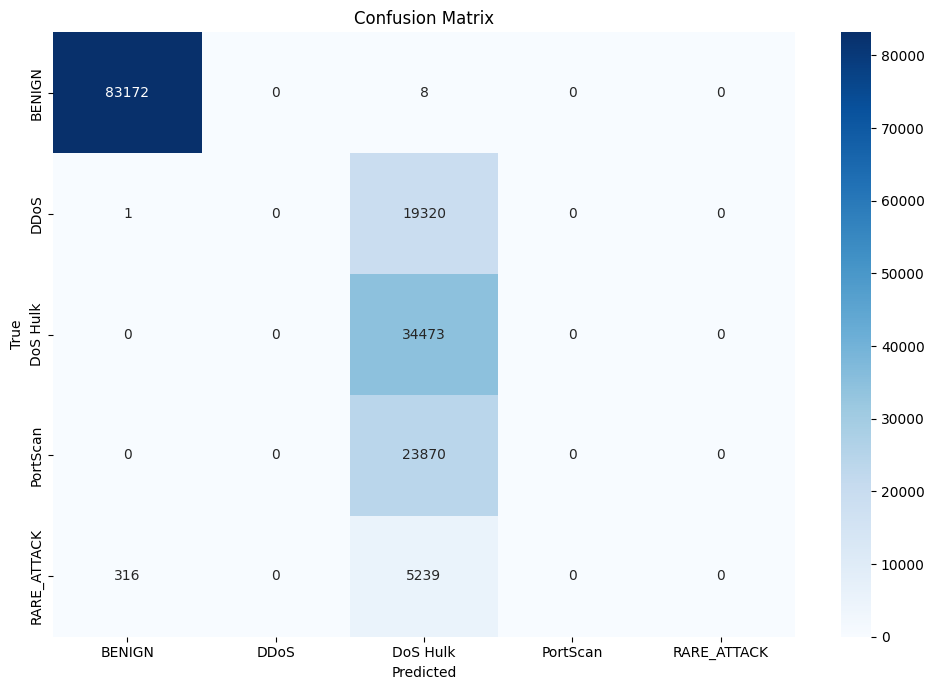


Macro F1 Score: 0.3171


In [ ]:
model, test_f1 = train_and_return_f1(
    best_params=study.best_params,
    model_class=HeteroGNN,
    data=data,
    device='cuda'
)